# 相对强弱市场
*强者越强，弱者越弱*

## 目录
1. 什么是相对强弱？
2. 怎么计算相对强弱？
3. 如何用图形展示相对强弱？
4. 如何用相对强弱来编写策略？

## 什么是相对强弱？
一段时间内某股票和本行业的股票或整个市场的比较，即对该股票市场表现的计量。

## 怎么计算相对强弱？
RS = Stock/Index

MOM_RS = Momentum(RS)

MOM_MOM = Momentum(MOM_RS)

## 如何用图形展示相对强弱？

In [32]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
warnings.filterwarnings('ignore')
# data = pd.Panel({s: pd.read_excel('threesymbol.xlsx', sheetname=s, index_col='datetime') 
#                    for s in ['BTCUSDT.binance', 'EOSUSDT.binance', 'ETHUSDT.binance']})
data = pd.read_excel('threesymbol.xlsx', sheetname='BTCUSDT.binance', index_col='datetime')

In [33]:
#Momentum_RS
import talib as ta
data['BTCUSDT.binance']=data.close
MOM_RS = ta.ROCR100(data.close.values, 20)
MOM_MOM = ta.ROCR100(MOM_RS, 20)
data_s = data['BTCUSDT.binance']
data1 = pd.Series(MOM_RS, index=data.index)
data2 = pd.Series(MOM_MOM, index=data.index)
data = pd.concat([data_s, data1, data2], axis=1)
data.columns = ['close',  'MOM_RS', 'MOM_MOM']

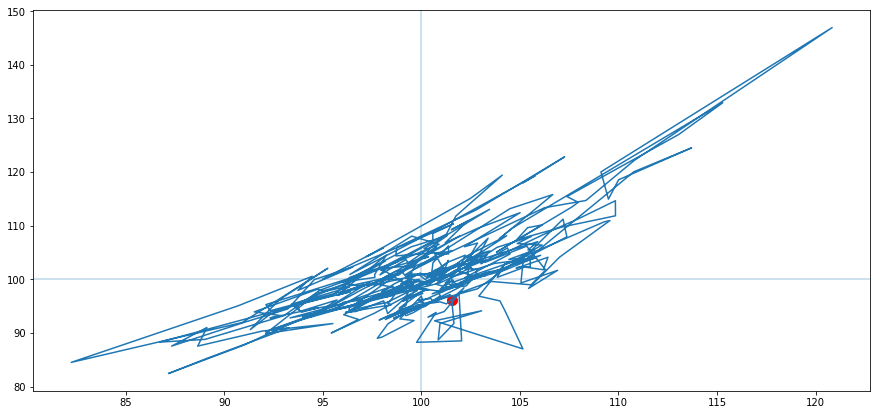

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(data1,data2)
plt.axhline(100,alpha=0.3)
plt.axvline(100,alpha=0.3)
X=data1.iloc[-1]
Y=data2.iloc[-1]
plt.scatter(X,Y,color='r', s=100)
plt.show()

## 如何用相对强弱来编写策略？
**买入时机：**

第一象限：（MOM_RS>100, MOM_MOM>100）

第四象限：（MOM_RS< 100, MOM_MOM >100）

**卖出时机**

第二象限：（MOM_RS > 100, MOM_MOM < 100）

第三象限：（MOM_RS< 100, MOM_MOM < 100）

In [ ]:
#Relative_Strength
    # 策略参数
    ROCRPeriod = 80
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    ROCRsignal = {}  
    transactionPrice = {}
    
    #设置变量
    self.setArrayManagerSize(200)
    self.ROCRsignal = {s: 0 for s in self.symbolList}
    self.transactionPrice = {s: 0 for s in self.symbolList}
    
            # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

     #计算信号
        MOM = ta.ROCR100(am3.close, self.ROCRPeriod)
        if len(MOM) > self.ROCRPeriod:
            MOM_MOM = ta.ROCR100(MOM, self.ROCRPeriod)

            if (MOM_MOM[-1] > 100) and (MOM_MOM[-2] < 100):
                self.ROCRsignal[symbol] = 1
            elif (MOM_MOM[-1] < 100) and (MOM_MOM[-2] > 100):
                self.ROCRsignal[symbol] = -1
            else:
                self.ROCRsignal[symbol] = 0

            if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
                if self.ROCRsignal[symbol] == 1:
                    self.buy(symbol, bar.close * 1.02, self.lots)
                if self.ROCRsignal[symbol] == -1:
                    self.short(symbol, bar.close * 0.98, self.lots)


    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price


## 作业
根据以上代码做出其他象限进场的策略